#  <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Homework 7: Classification with Logistic Regression, LDA/QDA, and Trees


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:**
<br><BR>

Avriel Epps, Erin Williams
<hr style="height:2pt">

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

<div class='exercise'><b> Question 1 [20 pts]: Overview of Multiclass Thyroid Classification </b></div>

In this problem set you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw7.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was [obtained from the UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Thyroid+Disease); for this assignment we chose two predictors so we can visualize the decision boundaries.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore different methods for multiclass classification.

For most of this problem set, we'll measure overall classification accuracy as the fraction of observations classified correctly.



**1.1** Load the data and examine its structure. How many instances of each class are there in our dataset? In particular, what is the ratio of the number of observations in class 2 (hyperthyroidism) to the number of observations in class 3 (hypothyroidism)? We'll refer to this as the *hyper-to-hypo ratio*.

**1.2**: We're going to split this data into a 50% training set and a 50% test set. But since our dataset is small, we need to make sure we do it correctly. Let's see what happens when we *don't* split correctly: for each of 100 different random splits of the data into 50% train and 50% test, compute the hyper-to-hypo for the observations end up in the training set. Plot the distribution of the hyper-to-hypo ratio; on your plot, also mark the hyper-to-hypo ratio that you found in the full dataset. Discuss how representative the training and test sets are likely to be if we were to have selected one of these random splits.

**1.3** Now, we'll use the `stratify` option to split the data in such a way that the relative class frequencies are preserved (the code is provided). Make a table showing how many observations of each class ended up in your training and test sets. Verify that the hyper-hypo ratio is roughly the same in both sets.

**1.4** Provide the scatterplot of the predictors in the (training) data in a way that clearly indicates which class each observation belongs to.

**1.5**: When we first start working with a dataset or algorithm, it's typically a good idea to figure out what *baselines* we might compare our results to. For regression, we always compared against a baseline of predicting the mean (in computing $R^2$). For classification, a simple baseline is always predicting the *most common class*. What "baseline" accuracy can we achieve on the thyroid classification problem by always predicting the most common class? Assign the result to `baseline_accuracy` so we can use it later. (**note: don't look at the test set until instructed**)

**1.6** Make a decision function to separate these samples using no library functions; just write out your logic by hand. Your manual classifier doesn't need to be well-tuned (we'll be exploring algorithms to do that!); it only needs to (1) predict each class at least once, and (2) achieve an accuracy at least 10% greater accurate than predicting the most likely class. Use the `overlay_decision_boundaries` function provided above to overlay the decision boundaries of your function on the training set. (Note that the function modifies an existing plot, so call it after plotting your points.)

Based on your exploration, do you think a linear classifier (i.e., a classifier where all decision boundaries are line segments) could achieve above 85% accuracy on this dataset? Could a non-linear classifier do better? What characteristics of the data lead you to these conclusions?

**1.1**

In [3]:
# your code here
data = pd.read_csv('dataset_HW7.csv')
display(data.head())
display(data.describe())
display(data.info())

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1
1,0.693152,0.262372,1
2,0.262372,0.405472,1
3,-0.105349,1.064714,1
4,0.000010,1.131405,1


,Biomarker 1,Biomarker 2,Diagnosis
count,215.000000,215.000000,215.000000
mean,0.414441,0.303155,1.441860
std,0.888106,2.174369,0.726737
min,-2.302485,-11.512925,1.000000
25%,0.000010,-0.510809,1.000000
50%,0.262372,0.693152,1.000000
75%,0.530634,1.410989,2.000000
max,4.032469,4.030695,3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 3 columns):
Biomarker 1    215 non-null float64
Biomarker 2    215 non-null float64
Diagnosis      215 non-null int64
dtypes: float64(2), int64(1)
memory usage: 5.1 KB


None

In [4]:
# your code here
(data['Diagnosis']).value_counts()


1    150
2     35
3     30
Name: Diagnosis, dtype: int64

In [5]:
data['Diagnosis'].value_counts(normalize=True)

1    0.697674
2    0.162791
3    0.139535
Name: Diagnosis, dtype: float64

*Answer*: There are 150 instances of normal thyroid levels, 35 instances of hyperthroidism, and 30 cases of hypothyroidism. The hyper-to-hypo ratio is 7:6. 

**1.2**We're going to split this data into a 50% training set and a 50% test set. But since our dataset is small, we need to make sure we do it correctly. Let's see what happens when we *don't* split correctly: for each of 100 different random splits of the data into 50% train and 50% test, compute the hyper-to-hypo for the observations end up in the training set. Plot the distribution of the hyper-to-hypo ratio; on your plot, also mark the hyper-to-hypo ratio that you found in the full dataset. Discuss how representative the training and test sets are likely to be if we were to have selected one of these random splits.

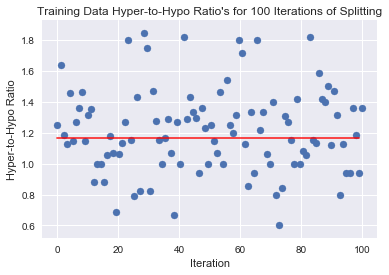

In [6]:
ratio_list = []
for i in range (0, 100):
    data_train, data_test = train_test_split(data, test_size=.5)
    counts_train = (data_train['Diagnosis']).value_counts()
    train_hyper = counts_train[2]
    train_hypo = counts_train[3]
    ratio = train_hyper/train_hypo
    ratio_list.append(ratio)

x=np.linspace(0, 100, 100)
y=0*x + (7/6)

len(ratio_list)
    
plt.scatter(x,ratio_list)
plt.plot(y, color = 'r', alpha = 0.8)
plt.title("Training Data Hyper-to-Hypo Ratio's for 100 Iterations of Splitting")
plt.xlabel("Iteration")
plt.ylabel("Hyper-to-Hypo Ratio");

**Answer**: Because we've failed to stratify the data and there are so few instances of hyper-and hypo-thyroidism, we see that the hyper-to-hypo ratio varies from about 0.6 up to 2.3 (vs. the value of 1.6 calculated from the original data). These training and test sets are unlikely to give a good represenataion of the data if we split this way.


**1.3** Now, we'll use the `stratify` option to split the data in such a way that the relative class frequencies are preserved (the code is provided). Make a table showing how many observations of each class ended up in your training and test sets. Verify that the hyper-hypo ratio is roughly the same in both sets.

In [7]:
data_train, data_test = train_test_split(data, test_size=.5, stratify=data.Diagnosis, random_state=99);

In [8]:
len(data_train), len(data_test)

(107, 108)

In [9]:
#Still need to put this into a new table.
display(data_test.groupby('Diagnosis').count())
display(data_train.groupby('Diagnosis').count())

,Biomarker 1,Biomarker 2
Diagnosis,,
1,75,75
2,18,18
3,15,15


,Biomarker 1,Biomarker 2
Diagnosis,,
1,75,75
2,17,17
3,15,15


**1.4** Provide the scatterplot of the predictors in the (training) data in a way that clearly indicates which class each observation belongs to.

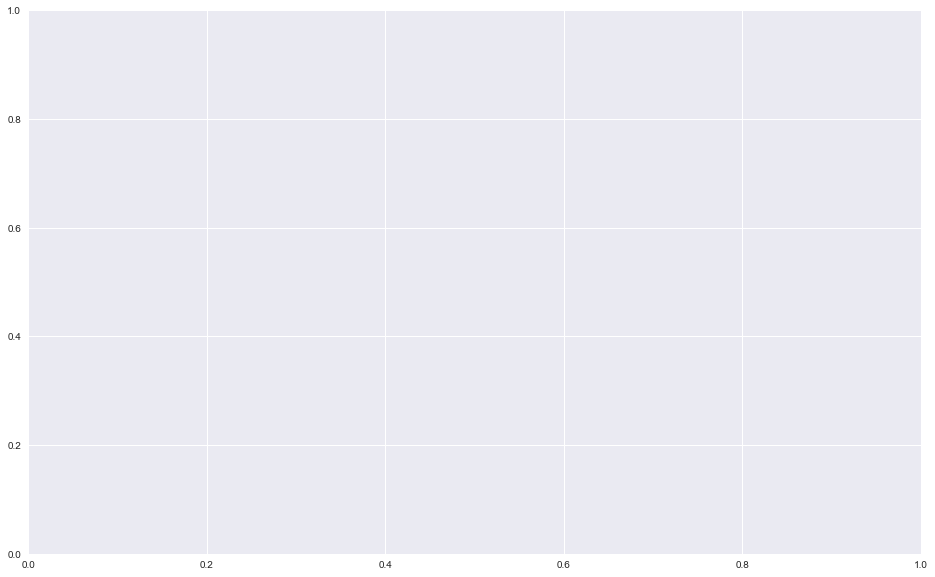

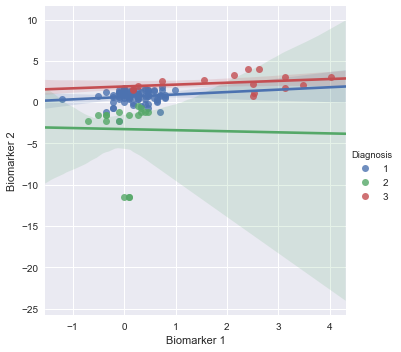

In [10]:
fig, ax = plt.subplots(1,1, figsize=(16,10))
ax = sns.lmplot(x="Biomarker 1", y="Biomarker 2", hue="Diagnosis", data=data_train)
#Why is this giving me a diagnosis of zero??

**1.5**: When we first start working with a dataset or algorithm, it's typically a good idea to figure out what *baselines* we might compare our results to. For regression, we always compared against a baseline of predicting the mean (in computing $R^2$). For classification, a simple baseline is always predicting the *most common class*. What "baseline" accuracy can we achieve on the thyroid classification problem by always predicting the most common class? Assign the result to `baseline_accuracy` so we can use it later. (**note: don't look at the test set until instructed**)

In [11]:
y_train = data_train['Diagnosis']
X_train = data_train.drop(['Diagnosis'], axis =1)
y_test = data_test['Diagnosis']
X_test = data_test.drop(['Diagnosis'], axis =1)

# Create dummy classifer
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" model
dummy.fit(X_train, y_train)

# Get accuracy score
baseline_accuracy = dummy.score(X_train, y_train) 
baseline_accuracy

0.32710280373831774

**1.6** Make a decision function to separate these samples using no library functions; just write out your logic by hand. Your manual classifier doesn't need to be well-tuned (we'll be exploring algorithms to do that!); it only needs to (1) predict each class at least once, and (2) achieve an accuracy at least 10% greater accurate than predicting the most likely class. Use the `overlay_decision_boundaries` function provided above to overlay the decision boundaries of your function on the training set. (Note that the function modifies an existing plot, so call it after plotting your points.)

In [13]:
def decision_function():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-13-243e47350f2e>, line 2)

In [14]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X)
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

In [15]:
# Update the following function:
def predict_manual_one_sample(x):
    return 0

In [16]:
# your code here:


In [17]:
def predict_manual(X):
    return np.array([predict_manual_one_sample(x) for x in X])

manual_predictions = predict_manual(X)
accuracy = accuracy_score(y, manual_predictions)
print("Accuracy:", accuracy)

NameError: name 'X' is not defined

In [18]:
assert accuracy >= (baseline_accuracy * 1.10), "Accuracy too low"
assert all(np.sum(manual_predictions == i) > 0 for i in [1, 2, 3]), "Should predict each class at least once."

NameError: name 'accuracy' is not defined

In [19]:
# Your code here


**Your answer here**


<div class='exercise'><b> Question 2 [20 pts]: Multiclass Logistic Regression</b></div>



**2.1** Fit two one-vs-rest logistic regression models using sklearn. For the first model, use the train dataset as-is (so the decision boundaries will be linear); for the second model, also include quadratic and interaction terms. For both models, use $L_2$ regularization, tuning the regularization parameter using 5-fold cross-validation. 

For each model, make a plot of the training data with the decision boundaries overlayed.

**2.2** Interpret the decision boundaries:
- Do these decision boundaries make sense?
- What does adding quadratic and interaction features do to the shape of the decision boundaries? Why?
- How do the different models treat regions where there are few samples? How do they classify such samples?

**2.3** Compare the performance of the two logistic regression models above using 5-fold cross-validation. Which model performs best? How confident are you about this conclusion? Does the inclusion of the polynomial terms in logistic regression yield better accuracy compared to the model with only linear terms? Why do you suspect it is better or worse?

*Hint*: You may use the `cross_val_score` function for cross-validation.

**2.1** Fit two one-vs-rest logistic regression models using sklearn. For the first model, use the train dataset as-is (so the decision boundaries will be linear); for the second model, also include quadratic and interaction terms. For both models, use $L_2$ regularization, tuning the regularization parameter using 5-fold cross-validation. 

For each model, make a plot of the training data with the decision boundaries overlayed.

*Hint*: You should use `LogisticRegressionCV`. For the model with quadratic and interaction terms, use the following Pipeline:

In [20]:
polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="multinomial"))

# Note that you can access the logistic regression classifier itself by
# polynomial_logreg_estimator.named_steps['logisticregressioncv']

In [21]:
# your code here
is_healthy = (y_train == 1).astype(int)
is_hyper = (y_train == 2).astype(int)
is_hypo = (y_train == 3).astype(int)

In [22]:
# your code here
healthy_vs_rest = LogisticRegressionCV(solver='newton-cg', cv= 5, penalty = 'l2').fit(X_train, is_healthy)
hyper_vs_rest = LogisticRegressionCV(solver='newton-cg', cv=5, penalty = 'l2').fit(X_train, is_hyper)
hypo_vs_rest = LogisticRegressionCV(solver='newton-cg', cv= 5, penalty = 'l2').fit(X_train, is_hypo)

In [23]:
# your code here
display(healthy_vs_rest)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='newton-cg', tol=0.0001,
           verbose=0)

In [24]:
X_train_poly = X_train
X_train_poly['Biomarker 1^2']=X_train_poly['Biomarker 1']**2
X_train_poly['Biomarker 2^2']=X_train_poly['Biomarker 2']**2
X_train_poly['Biomarker 1 * Biomarker 2']=X_train_poly['Biomarker 1']*X_train_poly['Biomarker 2']

In [25]:
healthy_vs_rest_poly = LogisticRegressionCV(solver='newton-cg', cv= 5, penalty = 'l2').fit(X_train_poly, is_healthy)
hyper_vs_rest_poly = LogisticRegressionCV(solver='newton-cg', cv=5, penalty = 'l2').fit(X_train_poly, is_hyper)
hypo_vs_rest_poly = LogisticRegressionCV(solver='newton-cg', cv= 5, penalty = 'l2').fit(X_train_poly, is_hypo)

In [26]:
X = np.linspace(0,2,2).reshape(1,-1)
overlay_decision_boundary((0,0), healthy_vs_rest.predict(X))

AttributeError: 'tuple' object has no attribute 'get_xlim'

**2.2**

**Your answer here**


**2.3**

In [27]:
# your code here


In [28]:
# your code here


**Your answer here**


<div class='exercise'><b> Question 3 [20 pts]: Discriminant Analysis</b></div>



**3.1** Consider the following synthetic dataset with two classes. A green star marks a test observation; which class do you think it belongs to? How would LDA classify that observation? How would QDA? Explain your reasoning.

**3.2** Now let's return to the thyroid dataset. Make a table of the total variance of each class for each biomarker.

**3.3** Fit LDA and QDA on the thyroid data, and plot the decision boundaries. Comment on how the decision boundaries differ. How does the difference in decision boundaries relate to characteristics of the data, such as the table you computed above?

**3.1**

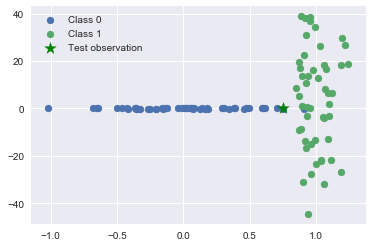

In [29]:
X_blobs, y_blobs = make_blobs(centers=[[0., 0.], [1., 0.]], cluster_std=[[.4, .1], [.1, 20.]], random_state=0)
plt.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0")
plt.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
plt.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
plt.legend();

**Answer** It seems to us that the test observation would be in Class 0. LDA would almost certainly classify it as zero, while QDA might classify it as one. Although there are data in Class 1 that share the same x value as the test observation, there are none that share the same y value (or come close); however, the test observation seems to be very close to existing x and y values for Class 0, which is why I would classify it in that group.

**3.2** Now let's return to the thyroid dataset. Make a table of the total variance of each class for each biomarker.

In [30]:
data.groupby('Diagnosis').var()

,Biomarker 1,Biomarker 2
Diagnosis,,
1,0.151141,1.932455
2,0.308598,8.202238
3,1.092134,0.901756


**3.3** Fit LDA and QDA on the thyroid data, and plot the decision boundaries. Comment on how the decision boundaries differ. How does the difference in decision boundaries relate to characteristics of the data, such as the table you computed above?

In [31]:
lda = LinearDiscriminantAnalysis(store_covariance=True)#, priors=[1,1,1])
qda = QuadraticDiscriminantAnalysis(store_covariance=True)#, priors=[1,1,1])

lda.fit(X_train, y_train)

qda.fit(X_train, y_train)

lda.predict(X_test)

qda.predict(X_test)


print('LDA accuracy train={:.2%}, test: {:.2%}'.format(
    lda.score(X_train, y_train), lda.score(X_test, y_test)))
print('QDA accuracy train={:.2%}, test: {:.2%}'.format(
    qda.score(X_train, y_train), qda.score(X_test, y_test)))


ValueError: X has 2 features per sample; expecting 5

In [32]:
def scatter_diagnoses(ax, df, columns, class_labels, class_colors, s=5,
                  xlim=[-4, 4], ylim=[-4, 4], **kw):
    for idx, (color, name) in enumerate(zip(class_colors, class_labels)):
        subset = df[df['Diagnosis'] == name]
        ax.scatter(
            subset[columns[0]], subset[columns[1]],
            label=name,
            c=color, s=s, **kw)
    ax.set(xlabel=columns[0], ylabel=columns[1], xlim=xlim, ylim=ylim)
    ax.legend()

AttributeError: module 'seaborn' has no attribute 'scatterplot'

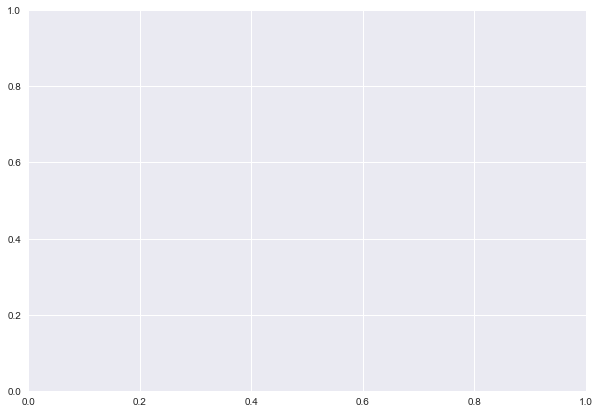

In [33]:
f, axes = plt.subplots(figsize = (10,7))
data_sample = data_train.sample(frac=.05)

ax = sns.scatterplot(x="Biomarker 1", y="Biomarker 2", hue="Diagnosis", data=data_train)
overlay_decision_boundary(ax, lda, colors=class_colors, desaturate=.3)
ax.set_title('LDA')


AttributeError: module 'seaborn' has no attribute 'scatterplot'

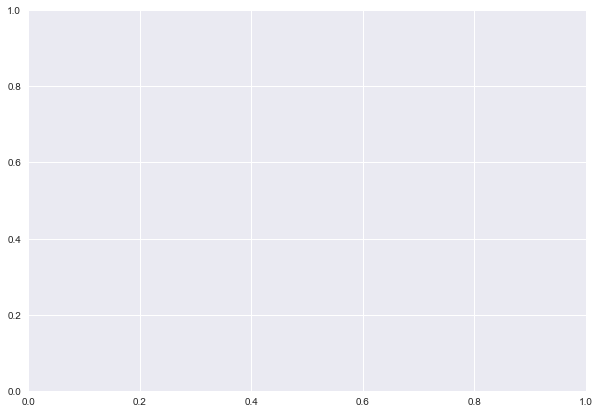

In [34]:
f, axes = plt.subplots(figsize = (10,7))
data_sample = data_train.sample(frac=.05)

ax = sns.scatterplot(x="Biomarker 1", y="Biomarker 2", hue="Diagnosis", data=data_train)
overlay_decision_boundary(ax, qda, colors=class_colors, desaturate=.3)
ax.set_title('QDA')


<div class='exercise'> <b> Question 4 [20 pts]: Fit Decision Trees </b> </div> 


We next try out decision trees for thyroid classification. For the following questions, you should use the *Gini* index as the splitting criterion while fitting the decision tree. 

*Hint:* You should use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth.



**4.1**. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the accuracy as a function of the maximum tree depth, on the training set and the mean score on the validation sets for 5-fold CV. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about how this tree will generalize? Which hyperparameter setting gives the best cross-validation performance?

**4.2**: Visualize the decision boundaries of the best decision tree you just fit. How are the shapes of the decision boundaries for this model different from the other methods we have seen so far? Given an explanation for your observation.

**4.3** Explain *in words* how the best fitted model diagnoses 'hypothyroidism' for a new patient. You can use the code below to examine the structure of the best decision tree.

**4.1**

In [45]:
for i in range(2,11):
    cls = DecisionTreeClassifier(max_depth = i)
    score = cross_val_score(cls, X_train, y_train, cv=5)
    mean = (score[0]+score[1]+score[2]+score[3]+score[4])/5
    words = "The mean is: "
    print(i, score, words, mean)

2 [0.90909091 0.86363636 0.9047619  0.80952381 0.95238095] The mean is:  0.8878787878787879
3 [0.90909091 0.86363636 0.9047619  0.80952381 0.95238095] The mean is:  0.8878787878787879
4 [0.90909091 0.81818182 0.85714286 0.76190476 0.9047619 ] The mean is:  0.8502164502164502
5 [0.90909091 0.77272727 0.85714286 0.85714286 0.95238095] The mean is:  0.8696969696969697
6 [0.90909091 0.77272727 0.9047619  0.85714286 0.95238095] The mean is:  0.8792207792207792
7 [0.90909091 0.77272727 0.9047619  0.85714286 0.95238095] The mean is:  0.8792207792207792
8 [0.90909091 0.77272727 0.9047619  0.85714286 0.95238095] The mean is:  0.8792207792207792
9 [0.90909091 0.77272727 0.9047619  0.85714286 0.95238095] The mean is:  0.8792207792207792
10 [0.90909091 0.77272727 0.85714286 0.85714286 0.95238095] The mean is:  0.8696969696969697


In [38]:
from sklearn import tree

def fit_and_plot_dt(x, y, depth, title, ax, plot_data=True, fill=True, color='Blues'):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax, plot_data, fill, color)
    
    return ax

In [40]:
def plot_tree_boundary(x, y, model, title, ax, plot_data=True, fill=True, color='Greens'):
    if plot_data:
        # PLOT DATA
        ax.scatter(x[y==1,0], x[y==1,1], c='green')
        ax.scatter(x[y==0,0], x[y==0,1], c='grey')
    
    # CREATE MESH
    interval = np.arange(min(x.min(), y.min()),max(x.max(), y.max()),0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if fill:
        ax.contourf(x1, x2, yy, alpha=0.1, cmap=color)
    else:
        ax.contour(x1, x2, yy, alpha=0.1, cmap=color)
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [44]:
# your code here
for i in range(2,11):
    fit_and_plot_dt(X_train,y_train, i, title = "Depth", ax = 1)

AttributeError: 'int' object has no attribute 'scatter'

In [ ]:
# your code here


In [ ]:
# your code here


**4.2**

In [ ]:
# your code here


**Your answer here**


**4.3**

*Entirely optional note:* You can also generate a visual representation using the `export_graphviz`. However, viewing the generated GraphViz file requires additional steps. One approach is to paste the generated graphviz file in the text box at http://www.webgraphviz.com/. Alternatively, you can run GraphViz on your own computer, but you may need to install some additional software. Refer to the [Decision Tree section of the sklearn user guide](http://scikit-learn.org/stable/modules/tree.html#classification) for more information.

In [ ]:
# This code is adapted from
# http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def show_tree_structure(clf):
    tree = clf.tree_

    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print(f"The binary tree structure has {n_nodes} nodes:\n")
    
    for i in range(n_nodes):
        indent = node_depth[i] * "  "
        if is_leaves[i]:
            prediction = clf.classes_[np.argmax(tree.value[i])]
            print(f"{indent}node {i}: predict class {prediction}")
        else:
            print("{}node {}: if X[:, {}] <= {:.3f} then go to node {}, else go to node {}".format(
                indent, i, feature[i], threshold[i], children_left[i], children_right[i]))

In [ ]:
# your code here


In [ ]:
# your code here


**Your answer here**


<div class='exercise'><b> Question 5 [18 pts]: k-NN and Model comparison </b> </div>

We have now seen six different ways of fitting a classification model: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **decision trees**, and in this problem we'll add **k-NN**. Which of these methods should we use in practice for this problem? To answer this question, we now compare and contrast these methods.



**5.1** Fit a k-NN classifier with uniform weighting to the training set. Use 5-fold CV to pick the best $k$.

*Hint: Use `KNeighborsClassifier` and `cross_val_score`.*

**5.2** Plot the decision boundaries for each of the following models that you fit above. For models with hyperparameters, use the values you chose using cross-validation.
- Logistic Regression (linear)
- Logistic Regression (polynomial)
- Linear Discriminant Analysis 
- Quadratic Discriminant Analysis
- Decision Tree
- k-NN

Comment on the difference in the decision boundaries between the following pairs of models. Why does this difference make sense given how the model works?
- Linear logistic regression; LDA
- Quadratic logistic regression; QDA.
- k-NN and whichever other model has the most complex decision boundaries

**5.3** Describe how each model classifies an observation from the test set in one short sentence for each (assume that the model is already fit). For example, for the linear regression classifier you critiqued in hw5, you might write: "It classifies the observation as class 1 if the dot product of the feature vector with the the model coefficients (with constant added) exceeds 0.5."

- Logistic Regression (One-vs-Rest)
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis
- k-Nearest-Neighbors Classifier
- Decision Tree

**5.4** Estimate the validation accuracy for each of the models. Summarize your results in a graph or table. (Note: for some models you have already run these computations; it's ok to redo them here if it makes your code cleaner.)

**5.5** Based on everything you've found in this question so far, which model would you expect to perform best on our test data? 

Now evaluate each fitted model's performance on the test set. Also, plot the same decision boundaries as above, but now showing the test set. How did the overall performance compare with your performance estimates above? Which model actually performed best? Why do you think this is the case?

**5.6**. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Interpretability

If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? Justify your choice in terms of at least 3 different aspects.

**5.1**

In [ ]:
# your code here


**5.2**

In [ ]:
# Your code here


**your answer here**


**5.3**

**Your answer here**


**5.4**

In [ ]:
# your code here


In [ ]:
# your code here


In [ ]:
# your code here


**Your answer here**


**5.5**

In [ ]:
# your code here


In [ ]:
# your code here


**your answer here**

**5.6**

**your answer here**


<div class='exercise'><b> Question 6: [2 pts] Including an 'abstain' option </b></div>
**Note this question is only worth 2 pts. **

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost.  How could one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.



**6.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 2? Note that this needs to be evaluated on the patients in the test set. 

**6.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.



**6.1**

**Your answer here**


In [ ]:
# your code here


In [ ]:
# your code here


**6.2**

**Your answer here**
